# The Structural Relationship of Childcare Expenses and Workforce Attachment
## Jesús Pacheco & Dave Foote

In [153]:
#imports
import numpy as np
import pandas as pd
import scipy.stats as sts
import math
from matplotlib import pyplot as plt
import requests
import scipy.optimize as opt
from statsmodels.discrete.discrete_model import Probit
import statsmodels.api as sm
import structural_childcare as sc
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [165]:
#read data
df = pd.read_csv('../rdf_subset.csv')
df['intercept'] = 1
state_map = {1: 'Alabama', 2: 'Alaska', 4: 'Arizona', 5: 'Arkansas',
            6: 'California', 8: 'Colorado', 9: 'Connecticut', 10: 'Delaware',
            11: 'D.C.', 12: 'Florida', 13: 'Georgia', 15: 'Hawaii',
            16: 'Idaho', 17: 'Illinois', 18: 'Indiana', 19: 'Iowa',
            20: 'Kansas', 21: 'Kentucky', 22: 'Louisiana', 23: 'Maine',
            24: 'Maryland', 25: 'Massachusetts', 26: 'Michigan',
            27: 'Minnesota', 28: 'Mississippi', 29: 'Missouri', 30: 'Montana',
            31: 'Nebraska', 32: 'Nevada', 33: 'New Hampshire',
            34: 'New Jersey', 35: 'New Mexico', 36: 'New York',
            37: 'North Carolina', 38: 'North Datoka', 39: 'Ohio',
            40: 'Oklahoma', 41: 'Oregon', 42: 'Pennsylvania',
            44: 'Rhode Island', 45: 'South Carolina', 46: 'South Dakota',
            47: 'Tennessee', 48: 'Texas', 49: 'Utah', 50: 'Vermont',
            51: 'Virginia', 53: 'Washington', 54: 'West Virginia',
            55: 'Wisconsin', 56: 'Wyoming', 60: 'Puerto Rico and Island Areas',
            61: 'Foreign Country'}
bls_data = pd.read_csv('../bls_data.csv')

In [160]:
bls_data.State_number = bls_data.State_number.map(state_map)
bls_data.head()

,State_number,STATE_CC_COST,STATE_MEDIAN_WAGE
0,Alabama,9.02,16.22
1,Alaska,12.95,23.09
2,Arizona,11.51,17.80
3,Arkansas,9.44,15.31
4,California,12.67,20.40


In [161]:
state_cc_map = {}
state_medwage_map = {}
for i, r in bls_data.iterrows():
    state_cc_map[r['State_number']] = r['STATE_CC_COST']
    state_medwage_map[r['State_number']] = r['STATE_MEDIAN_WAGE']

In [168]:
df['STATE'] = df.State_number.map(state_map)
df['STATE_CC_COST'] = df.STATE.map(state_cc_map)
df['STATE_MEDIAN_WAGE'] = df.STATE.map(state_medwage_map)

In [169]:
#our functions:
def mle_beta_vec(df, xcols, init_guess, target_col, f):
    '''
    df = dataframe
    xcolumn names in list form
    init_guess in tuple form
    criterion function f
    doin the damn thing (write better comment later)
    '''
    x_mat = extract_x_matrix(df, xcols)
    y_vec = df[target_col]
    
    results_uncstr = opt.minimize(f, init_guess, method = 'L-BFGS-B', args=(x_mat, y_vec))
    VCV = results_uncstr.hess_inv.todense()
    error_info = get_st_error(xcols, VCV)

    return results_uncstr, VCV

def criterion(beta_guess, *args):
    '''
    beta_guess comes in as array
    '''
    x_mat, y_vec = args
    
    
    
    return logit_neglog_likelihood(beta_guess, y_vec, x_mat, prob_1)

def logit_neglog_likelihood(beta_vec, *args):
    '''
    calculate the log likelihood that the probability is correct
    '''
    y_vec, xm, probability_now = args
    p = list(probability_now(xm, beta_vec))
    y_vec = list(y_vec)
    rv = []
    for i, x in enumerate(p):
        to_add = ((y_vec[i] * math.log(x))) + ((1 - y_vec[i]) * math.log(1 - x))
        if to_add is not np.nan:
            rv.append(to_add)
    rv = pd.Series(rv)

    return -(rv.sum())

def prob_1(x_matrix, beta_vec):
    '''
    calculate probability a set of observations is a member of d1, using logit
    classification
    '''
    linear_kernel = x_matrix.dot(beta_vec)
    rv = np.exp(linear_kernel) / (1 + np.exp(linear_kernel))
    rv[rv == 1] = .999999

    return rv

def categorical_split(df):
    cond1 = (df['monthly_childcare_expenditure'] == 0)
    cond2 = (df['monthly_childcare_expenditure'] > 0)
    cond3 = (df['monthly_wage'] > 0)
    cond4 = (df['monthly_wage'] == 0)

    return df[cond1 & cond3], df[cond2 & cond3], df[cond4]

def extract_x_matrix(df, xcols):
    '''
    inputs: df with data and column names of your x variables
    output: n x k matrix of x data where n is #observations and k is
    #of columns
    '''
    
    return df[xcols].to_numpy()

def categorize_ds(df):
    '''
    input: df with H and F calculated columns
    output: same df with d1-4 columns denoting membership in groups d1, d2,
    d3, and d4 defined as such:
    d1 - H = 0, F = 0
    d2 - H = 0, F = 1
    d3 - H = 1, F = 0
    d4 - H = 1, F = 1
    '''

    df['d1'] = [1 if (r['H'] == 0) & (r['F'] == 0) else 0 for i, r in df.iterrows()]
    df['d2'] = [1 if (r['H'] == 0) & (r['F'] == 1) else 0 for i, r in df.iterrows()]
    df['d3'] = [1 if (r['H'] == 1) & (r['F'] == 0) else 0 for i, r in df.iterrows()]
    df['d4'] = [1 if (r['H'] == 1) & (r['F'] == 1) else 0 for i, r in df.iterrows()]
    
def get_st_error(col_names, VCV):
    '''
    given the order of the regressors and the variance covariance matrix from 
    the minimization, this function will return a dictionary mapping variable names
    to their standard erros, as well as print this information
    '''
    rd = {}
    for i, x in enumerate(col_names):
        rd[x] = np.sqrt(VCV[i, i])
        print("error for {}: ".format(x), rd[x])

    return rd

# So begins our estimation...
We use categorize_ds to estimate membership in our d groups such that:  
    d1 - H = 0, F = 0  
    d2 - H = 0, F = 1  
    d3 - H = 1, F = 0  
    d4 - H = 1, F = 1  

In [197]:
categorize_ds(df)
est_cols = ['intercept', 'k_under2', 'k_3to5', 'k_6to10', 'education', 'reg_ratio', 'monthly_job_hrs',
           'STATE_CC_COST', 'STATE_MEDIAN_WAGE']
generalized_guess = (.01, .1, .1, .1, .1, .1, .1, .1, .1)

In [198]:
results1, errors1 = mle_beta_vec(df, est_cols, generalized_guess, 'd1', criterion)

error for intercept:  80.28692573152215
error for k_under2:  1.9152815591507357
error for k_3to5:  2.555581536331829
error for k_6to10:  3.2577952995270665
error for education:  1.4288566994676877
error for reg_ratio:  1.931854902472556
error for monthly_job_hrs:  0.1463121752719345
error for STATE_CC_COST:  6.713039607013351
error for STATE_MEDIAN_WAGE:  8.319020334058692


In [205]:
for i, x in enumerate(est_cols):
    print("Beta Estimate for {} :".format(x), results1.x[i])

Beta Estimate for intercept : 6.296983432211815
Beta Estimate for k_under2 : 0.19065152212484593
Beta Estimate for k_3to5 : -0.48147701984084973
Beta Estimate for k_6to10 : -0.04330645883022377
Beta Estimate for education : -0.13653292280938206
Beta Estimate for reg_ratio : -0.04657905531443639
Beta Estimate for monthly_job_hrs : -0.17519044147553386
Beta Estimate for STATE_CC_COST : -0.06494735151879068
Beta Estimate for STATE_MEDIAN_WAGE : -0.0501623010614608


In [217]:
results2, errors2 = mle_beta_vec(df, est_cols, generalized_guess, 'd2', criterion)

error for intercept:  139.77389747050785
error for k_under2:  1.4539176249487862
error for k_3to5:  9.748317291321994
error for k_6to10:  0.7010744881384049
error for education:  0.5391225827681608
error for reg_ratio:  3.009276454838919
error for monthly_job_hrs:  0.3403553321532873
error for STATE_CC_COST:  1.2401137896095702
error for STATE_MEDIAN_WAGE:  5.254072440196225


In [218]:
for i, x in enumerate(est_cols):
    print("Beta Estimate for {} :".format(x), results2.x[i])

Beta Estimate for intercept : -4.542446857889552
Beta Estimate for k_under2 : -0.1928109193188857
Beta Estimate for k_3to5 : 0.48592603434349346
Beta Estimate for k_6to10 : -0.0019115098701744239
Beta Estimate for education : 0.15843223713178867
Beta Estimate for reg_ratio : -0.003315553287738873
Beta Estimate for monthly_job_hrs : -0.06736902980717349
Beta Estimate for STATE_CC_COST : -0.050841537355495715
Beta Estimate for STATE_MEDIAN_WAGE : 0.0715931541712103


In [212]:
results3, errors3 = mle_beta_vec(df, est_cols, generalized_guess, 'd3', criterion)

error for intercept:  156.46097495926648
error for k_under2:  1.61881581739398
error for k_3to5:  7.026457758207519
error for k_6to10:  16.464402793497946
error for education:  1.6117547947096227
error for reg_ratio:  3.4821158684363676
error for monthly_job_hrs:  0.49835232341052094
error for STATE_CC_COST:  14.912667629974251
error for STATE_MEDIAN_WAGE:  14.459576182251583


In [213]:
for i, x in enumerate(est_cols):
    print("Beta Estimate for {} :".format(x), results3.x[i])

Beta Estimate for intercept : -1.587426811602224
Beta Estimate for k_under2 : -0.31392746434599234
Beta Estimate for k_3to5 : -0.5952046016950591
Beta Estimate for k_6to10 : -0.06974517428571526
Beta Estimate for education : -0.12752135451421814
Beta Estimate for reg_ratio : 0.042966315115059564
Beta Estimate for monthly_job_hrs : 0.09230266337850383
Beta Estimate for STATE_CC_COST : 0.08970992527036241
Beta Estimate for STATE_MEDIAN_WAGE : -0.060299539042612836


In [214]:
results4, errors4 = mle_beta_vec(df, est_cols, generalized_guess, 'd4', criterion)

error for intercept:  48.845604894259104
error for k_under2:  1.9150137844992612
error for k_3to5:  13.157289919206944
error for k_6to10:  30.769417875204983
error for education:  0.9068652579251544
error for reg_ratio:  2.7996872749041777
error for monthly_job_hrs:  0.99698817120794
error for STATE_CC_COST:  1.9279411346972497
error for STATE_MEDIAN_WAGE:  4.6074361055495485


In [216]:
for i, x in enumerate(est_cols):
    print("Beta Estimate for {} :".format(x), results4.x[i])

Beta Estimate for intercept : -5.400230223795957
Beta Estimate for k_under2 : 0.2123688970465438
Beta Estimate for k_3to5 : 0.537558936335661
Beta Estimate for k_6to10 : -0.08754387099418527
Beta Estimate for education : 0.09515374557344712
Beta Estimate for reg_ratio : -0.023384360508957182
Beta Estimate for monthly_job_hrs : 0.08794747170809551
Beta Estimate for STATE_CC_COST : -0.0576754804498375
Beta Estimate for STATE_MEDIAN_WAGE : 0.05025115445375945


In [131]:
get_st_error(['intercept', 'k_under2'], variance_covariance_mat)

error for intercept:  0.03221000880027244
error for k_under2:  0.05068136340882821


{'intercept': 0.03221000880027244, 'k_under2': 0.05068136340882821}

Index(['Unnamed: 0', 'ssuid', 'monthly_childcare_expenditure', 'k_under2',
       'k_3to5', 'k_6to10', 'METRO', 'reg_ratio', 'criminal_records',
       'daycare_regulations', 'monthly_job_hrs', 'monthly_wage',
       'monthly_earned_income', 'monthly_unearned_income', 'education', 'age',
       'southern', 'log_expenditure', 'H', 'F', 'd1', 'd2', 'd3', 'intercept',
       'd4'],
      dtype='object')

0          114285765
1          114552343
2          114552369
3          418037420
4          418086894
5          418114194
6          418114602
7          418172676
8          418185142
9          418185162
10         418199950
11         418209291
12         418209316
13         418209852
14         418215316
15         418215449
16         418276060
17         418294283
18         418303449
19         418342067
20         418359831
21         418406167
22         418406566
23         418406660
24         418408197
25         418408831
26         418415746
27         418472070
28         418472765
29         418500162
            ...     
5878    881925098510
5879    881925098688
5880    881925342246
5881    881925342688
5882    881925609510
5883    881995023477
5884    881995023502
5885    881995034502
5886    881995034622
5887    881995068098
5888    881995068402
5889    881995092365
5890    881995092964
5891    881995138167
5892    881995204596
5893    881995209622
5894    88199

# Visualizing Underlying Data:

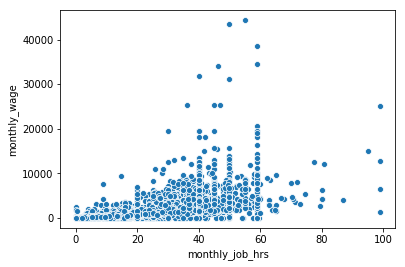

In [155]:
sns.scatterplot(x=df['monthly_job_hrs'], y=df['monthly_wage'])

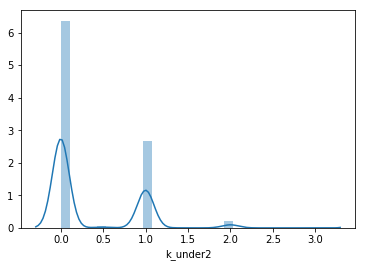

In [156]:
sns.distplot(df['k_under2'])

In [166]:
df.columns

Index(['Unnamed: 0', 'ssuid', 'monthly_childcare_expenditure', 'k_under2',
       'k_3to5', 'k_6to10', 'METRO', 'reg_ratio', 'criminal_records',
       'daycare_regulations', 'monthly_job_hrs', 'monthly_wage',
       'monthly_earned_income', 'monthly_unearned_income', 'education', 'age',
       'southern', 'State_number', 'log_expenditure', 'H', 'F', 'intercept'],
      dtype='object')